In [39]:
# Install Kaggle API
!pip install -q kaggle

# Upload Kaggle API key
from google.colab import files
uploaded = files.upload()

# Move Kaggle API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d dansbecker/food-101

# Unzip the dataset
!unzip -q food-101.zip -d food-101

# Check the contents of the directory
!!ls food-101


Saving kaggle.json to kaggle (2).json
food-101.zip: Skipping, found more recently modified local copy (use --force to force download)
replace food-101/food-101.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
غ
y
A
y


['food-101  food-101.zip']

In [ ]:
!pip install pyforest


  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14606 sha256=df7dcae5d43dfe699e155a7d4e0d5a6722e5e76a8fbe6a19f6d364663794a2c3
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest


In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
#@title imports
import pyforest
import random
import zipfile
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.image as mpim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import keras_tuner as kt

In [5]:
#@title Loading and Processing Class Names
import os
import random

# Specify the base path to the dataset
base_path = '/content/food-101/food-101/food-101'
images = '/content/food-101/food-101/food-101/images'

# Adjust the path to exclude any potential macOS-specific directories
class_names_dir = os.path.join(base_path, 'meta')

# List all files in the directory
try:
    files_in_dir = os.listdir(class_names_dir)

    # Find the file with class names (assuming it's the only txt file in the directory)
    class_names_file_path = [os.path.join(class_names_dir, file) for file in files_in_dir if file.endswith('.txt')][0]

    # Read class names from the file into a list
    with open(class_names_file_path, 'r', encoding='ISO-8859-1') as file:
        all_class_names = [line.strip() for line in file]

    # Choose 10 classes randomly
    chosen_classes = random.sample(all_class_names, 10)
    print(chosen_classes)

except FileNotFoundError:
    print(f"Directory '{class_names_dir}' or the class names file not found. Please check the dataset structure.")
except IndexError:
    print("No '.txt' file found in the class names directory.")
except UnicodeDecodeError:
    print("Error decoding the contents of the class names file. Please check the file encoding.")


['Ramen', 'Pulled pork sandwich', 'Escargots', 'Creme brulee', 'Caesar salad', 'Baby back ribs', 'Cup cakes', 'Ceviche', 'French fries', 'Guacamole']


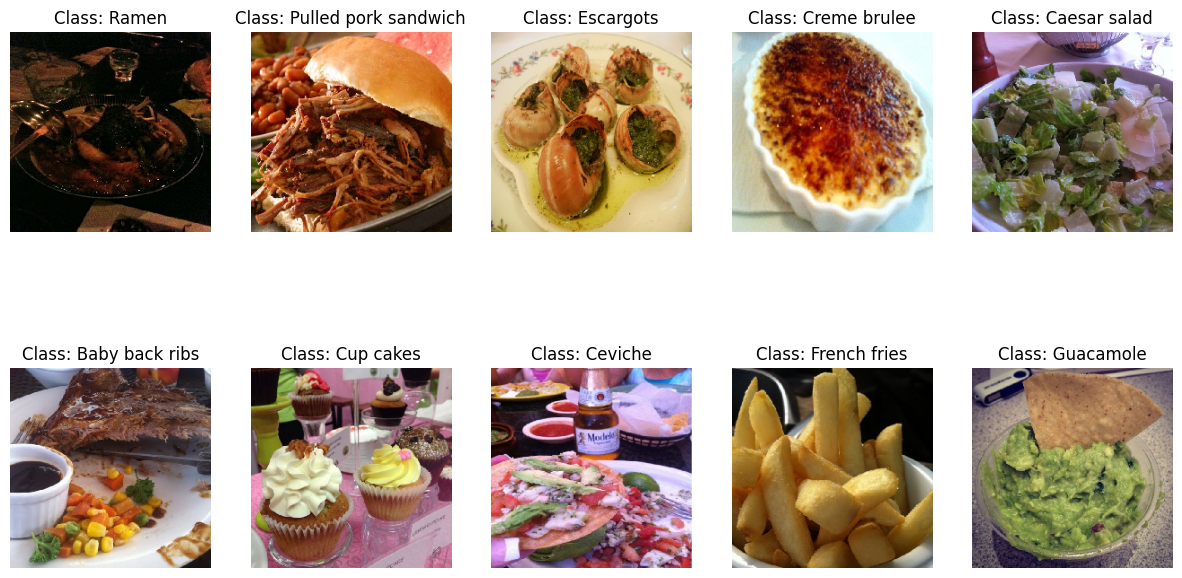

In [6]:
#@title visualize the random classes

from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

# Convert class names to lowercase and replace spaces with underscores
processed_classes = [class_name.lower().replace(' ', '_') for class_name in chosen_classes]

# Visualize the random classes
plt.figure(figsize=(15, 8))
for i, class_folder in enumerate(processed_classes):
    class_path = os.path.join(images, class_folder)

    # Get a random image from the class folder
    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)

    # Load and display the image
    img = load_img(image_path, target_size=(224, 224))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {chosen_classes[i]}")
    plt.axis('off')

plt.show()


In [10]:
#@title Create the model
model = models.Sequential()

# Add convolutional layers with activation and pooling
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(processed_classes), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
print(generator.class_indices)

# Extract class names from class_indices dictionary
class_names = [class_name for class_name, class_index in sorted(generator.class_indices.items(), key=lambda x: x[1])]
print(class_names)


{'paella': 0, 'bibimbap': 1, 'seaweed_salad': 2, 'club_sandwich': 3, 'churros': 4, 'scallops': 5, 'baklava': 6, 'spaghetti_bolognese': 7, 'edamame': 8, 'chicken_curry': 9}
['paella', 'bibimbap', 'seaweed_salad', 'club_sandwich', 'churros', 'scallops', 'baklava', 'spaghetti_bolognese', 'edamame', 'chicken_curry']


In [13]:
#@title Training the model + Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split the data into training and validation
)

batch_size = 32
# Use the same generator for both training and validation
generator = datagen.flow_from_directory(
    os.path.join(base_path, 'images'),  # Update this line
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # For training data
    classes=processed_classes
)

validation_generator = datagen.flow_from_directory(
    os.path.join(base_path, 'images'),  # Update this line
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # For validation data
    classes=processed_classes
)


# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    generator,
    epochs=7,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/7
250/250 [==============================] - 1281s 5s/step - loss: 2.2085 - accuracy: 0.1916 - val_loss: 1.9903 - val_accuracy: 0.2920
Epoch 2/7
250/250 [==============================] - 1300s 5s/step - loss: 1.9425 - accuracy: 0.3181 - val_loss: 1.9185 - val_accuracy: 0.3515
Epoch 3/7
250/250 [==============================] - 1216s 5s/step - loss: 1.8343 - accuracy: 0.3623 - val_loss: 1.7096 - val_accuracy: 0.4050
Epoch 4/7
250/250 [==============================] - 1303s 5s/step - loss: 1.7625 - accuracy: 0.3860 - val_loss: 1.6883 - val_accuracy: 0.4220
Epoch 5/7
250/250 [==============================] - 1181s 5s/step - loss: 1.6903 - accuracy: 0.4205 - val_loss: 1.5795 - val_accuracy: 0.4615
Epoch 6/7
250/250 [==============================] - 1259s 5s/step - loss: 1.6046 - accuracy: 0.4485 - val_loss: 1.5718 - val_accuracy: 0.4620
Epoch 7/7
250/250 [==============================] - 123

In [15]:
#@title Evaluate the model on the validation set
evaluation = model.evaluate(validation_generator)
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

63/63 [==============================] - 107s 2s/step - loss: 2.2846 - accuracy: 0.1035
Loss: 2.2846264839172363
Accuracy: 0.10350000113248825


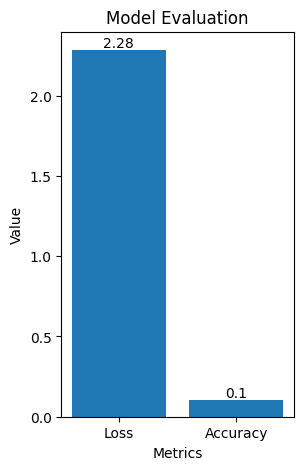

In [16]:
#@title Evaluation metrics
plt.figure(figsize=(3, 5))
bars = plt.bar(['Loss', 'Accuracy'], [evaluation[0], evaluation[1]])

# Add data labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.title('Model Evaluation')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.show()

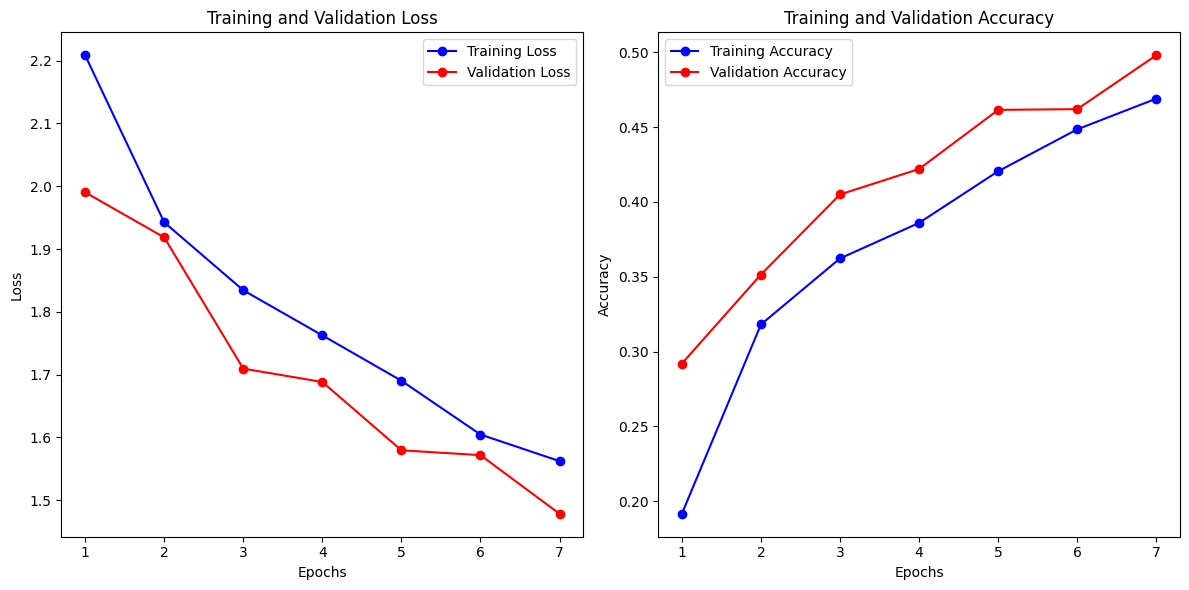

In [17]:
#@title Visualize the training history
# (loss and accuracy over epochs)
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()